In [2]:
"""
train_all_models_improved.py

Upgraded System:
- SMOTE applied inside CV (using imblearn pipeline)
- Imputation + Scaling unified
- All 12 models trained
- XGBoost includes hyperparameter tuning
- Save models + metrics + summary

Requirements:
pip install pandas numpy scikit-learn joblib imbalanced-learn xgboost lightgbm catboost
"""

import os
import json
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib

# Optional libraries
try:
    from xgboost import XGBClassifier
except:
    XGBClassifier = None

try:
    from lightgbm import LGBMClassifier
except:
    LGBMClassifier = None

try:
    from catboost import CatBoostClassifier
except:
    CatBoostClassifier = None


# -----------------------------------------
# CONFIG
# -----------------------------------------
DATA_PATH = "data/water_potability.csv"
MODELS_DIR = Path("models_improved")
METRICS_DIR = Path("metrics_improved")

MODELS_DIR.mkdir(exist_ok=True)
METRICS_DIR.mkdir(exist_ok=True)

N_SPLITS = 5
RANDOM_STATE = 42


# -----------------------------------------
# METRIC FUNCTION
# -----------------------------------------
def compute_metrics(y_true, y_pred, y_proba=None):
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m


# -----------------------------------------
# LOAD DATA
# -----------------------------------------
df = pd.read_csv(DATA_PATH)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
df.columns = df.columns.str.strip()

X = df.drop("Potability", axis=1)
y = df["Potability"]

X = X.apply(pd.to_numeric, errors="coerce")

# Base preprocessing inside pipeline
preprocess = [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
]


# -----------------------------------------
# ALL MODELS
# -----------------------------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=3000),
    "DecisionTree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM_linear": SVC(kernel="linear", probability=True),
    "SVM_rbf": SVC(kernel="rbf", probability=True),
    "GaussianNB": GaussianNB(),
    "SGDClassifier": SGDClassifier(max_iter=2000, tol=1e-3),
    "RandomForest": RandomForestClassifier(n_estimators=300),
    "AdaBoost": AdaBoostClassifier(n_estimators=300),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=300),
}

# Add boosting models if installed
if XGBClassifier:
    models["XGBoost_BASE"] = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
if LGBMClassifier:
    models["LightGBM"] = LGBMClassifier()
if CatBoostClassifier:
    models["CatBoost"] = CatBoostClassifier(verbose=0)


# -----------------------------------------
# HYPERPARAMETERS FOR XGBOOST
# -----------------------------------------
XGB_PARAM_GRID = {
    "model__n_estimators": [200, 400, 600],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 4, 5, 7],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.9, 1.0],
    "model__min_child_weight": [1, 3, 5],
}


# -----------------------------------------
# TRAINING LOOP
# -----------------------------------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
summary = []

for name, model in models.items():
    print("\n================================================")
    print(f"TRAINING MODEL: {name}")

    # Build full pipeline
    pipe = ImbPipeline(
        preprocess + [("model", model)]
    )

    # ------------------------
    # Special case: tuned XGBoost
    # ------------------------
    if name == "XGBoost_BASE":
        print("Running XGBoost Hyperparameter Search...")

        grid = GridSearchCV(
            pipe,
            XGB_PARAM_GRID,
            scoring="f1",
            cv=skf,
            verbose=2,
            n_jobs=-1,
        )
        grid.fit(X, y)

        best_model = grid.best_estimator_
        pipe = best_model
        print("Best XGB F1:", grid.best_score_)
        print("Best Params:", grid.best_params_)

    # ------------------------
    # CV PREDICTIONS FOR METRICS
    # ------------------------
    y_pred = cross_val_predict(pipe, X, y, cv=skf, method="predict", n_jobs=-1)

    # Probability (if supported)
    try:
        y_proba = cross_val_predict(pipe, X, y, cv=skf, method="predict_proba", n_jobs=-1)
        y_proba = y_proba[:, 1]
    except:
        y_proba = None

    met = compute_metrics(y, y_pred, y_proba)

    # Save detailed JSON
    with open(METRICS_DIR / f"{name}_metrics.json", "w") as f:
        json.dump(met, f, indent=4)

    # Fit full model on all data & save
    pipe.fit(X, y)
    joblib.dump(pipe, MODELS_DIR / f"{name}.pkl")

    print("Saved model:", MODELS_DIR / f"{name}.pkl")

    summary.append({
        "model": name,
        **met
    })


# -----------------------------------------
# SAVE SUMMARY CSV
# -----------------------------------------
summary_df = pd.DataFrame(summary).sort_values("f1", ascending=False)
summary_df.to_csv(METRICS_DIR / "summary.csv", index=False)

print("\nTraining Completed!")
print("Models saved in:", MODELS_DIR.resolve())
print("Metrics saved in:", METRICS_DIR.resolve())



TRAINING MODEL: LogisticRegression
Saved model: models_improved\LogisticRegression.pkl

TRAINING MODEL: DecisionTree
Saved model: models_improved\DecisionTree.pkl

TRAINING MODEL: KNN
Saved model: models_improved\KNN.pkl

TRAINING MODEL: SVM_linear
Saved model: models_improved\SVM_linear.pkl

TRAINING MODEL: SVM_rbf
Saved model: models_improved\SVM_rbf.pkl

TRAINING MODEL: GaussianNB
Saved model: models_improved\GaussianNB.pkl

TRAINING MODEL: SGDClassifier
Saved model: models_improved\SGDClassifier.pkl

TRAINING MODEL: RandomForest
Saved model: models_improved\RandomForest.pkl

TRAINING MODEL: AdaBoost
Saved model: models_improved\AdaBoost.pkl

TRAINING MODEL: GradientBoosting
Saved model: models_improved\GradientBoosting.pkl

TRAINING MODEL: XGBoost_BASE
Running XGBoost Hyperparameter Search...
Fitting 5 folds for each of 972 candidates, totalling 4860 fits


C:\Users\hvish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:54:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB F1: 0.5454807838099567
Best Params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__min_child_weight': 1, 'model__n_estimators': 200, 'model__subsample': 0.9}


C:\Users\hvish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:54:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved model: models_improved\XGBoost_BASE.pkl

TRAINING MODEL: LightGBM
[LightGBM] [Info] Number of positive: 1998, number of negative: 1998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 3996, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Saved model: models_improved\LightGBM.pkl

TRAINING MODEL: CatBoost
Saved model: models_improved\CatBoost.pkl

Training Completed!
Models saved in: C:\Users\hvish\Desktop\WATER POLLUTION IP\models_improved
Metrics saved in: C:\Users\hvish\Desktop\WATER POLLUTION IP\metrics_improved


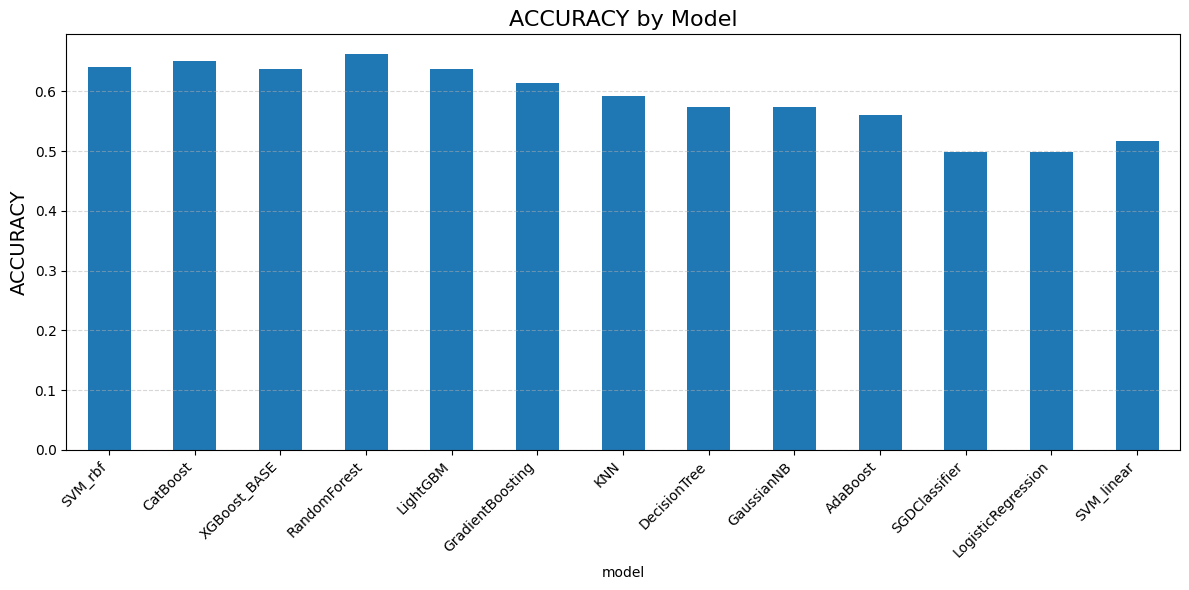

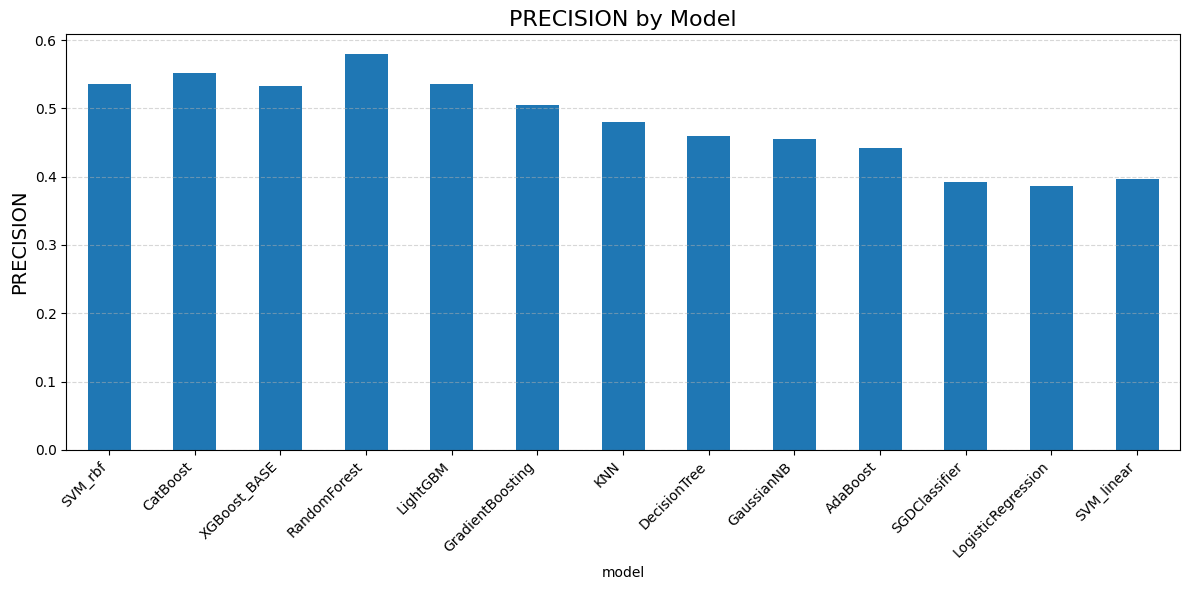

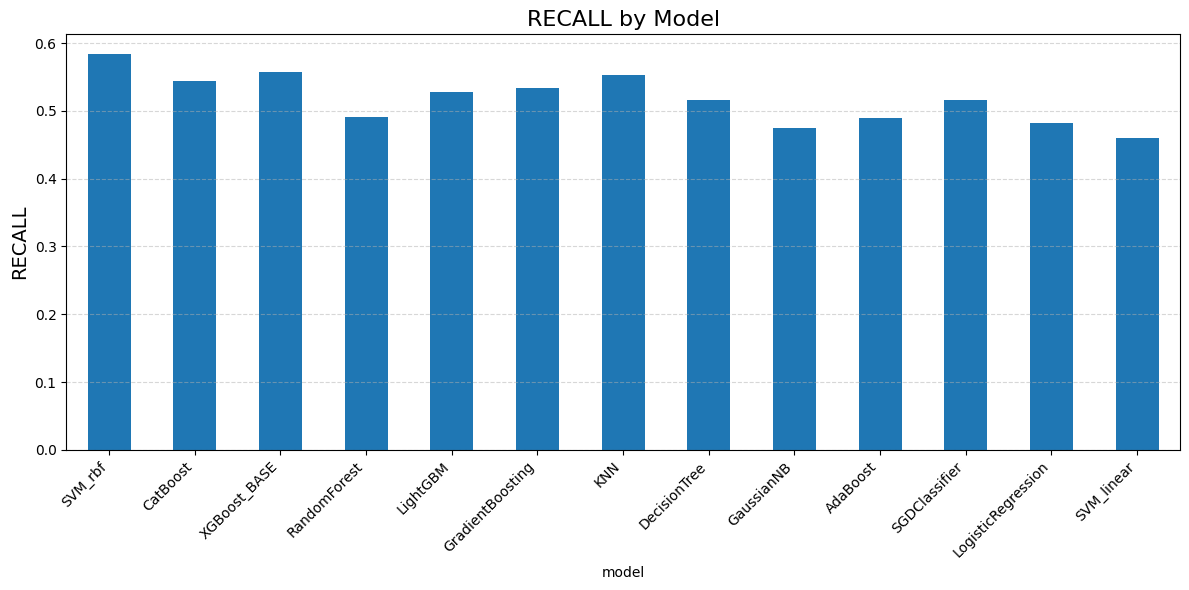

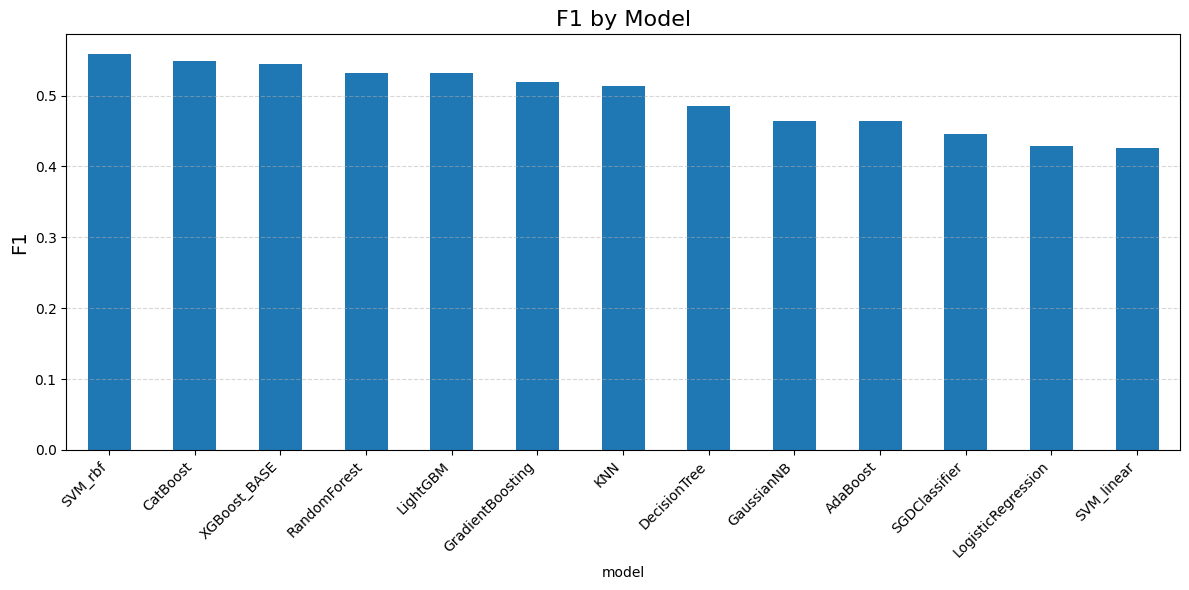

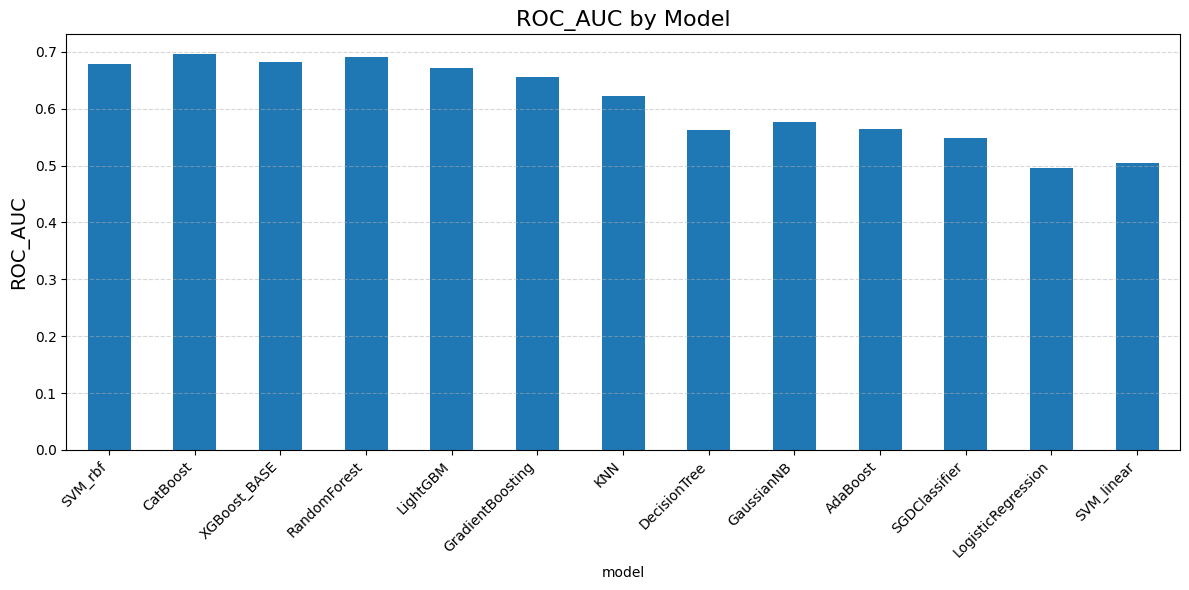

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV
df = pd.read_csv("metrics_improved/summary.csv")

# Set model names as index
df.set_index("model", inplace=True)

# Metrics to plot
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

# Plot settings
plt.style.use('default')
plt.rcParams["figure.figsize"] = (12, 6)

for metric in metrics:
    plt.figure()
    df[metric].plot(kind='bar')
    plt.title(f"{metric.upper()} by Model", fontsize=16)
    plt.ylabel(metric.upper(), fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
